In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import gymnasium as gym

from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import PPO, A2C

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

In [10]:
env_id = "CartPole-v1"
# The different number of processes that will be used
PROCESSES_TO_TEST = [1, 2, 4, 8, 16]
NUM_EXPERIMENTS = 3  # RL algorithms can often be unstable, so we run several experiments (see https://arxiv.org/abs/1709.06560)
TRAIN_STEPS = 5000
# Number of episodes for evaluation
EVAL_EPS = 20
ALGO = A2C

# We will create one environment to evaluate the agent on
eval_env = gym.make(env_id)

In [26]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f"Running for n_procs = {n_procs}")
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        # Here we use the "fork" method for launching the processes
        train_env = make_vec_env(env_id, 
                         n_envs=n_procs,
                         vec_env_cls=SubprocVecEnv, 
                         vec_env_kwargs=dict(start_method='fork'))

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(
            model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)
    # Important: when using subprocesses, don't forget to close them
    # otherwise, you may have memory issues when running a lot of experiments
    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1
Running for n_procs = 2
Running for n_procs = 4
Running for n_procs = 8
Running for n_procs = 16


In [29]:

from typing import List


def plot_training_results(
        training_steps_per_second: List[float], 
        reward_averages: List[float], 
        reward_std: List[float]):
    
    plt.figure(figsize=(9, 4))
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 2, 1)
    plt.errorbar(
        PROCESSES_TO_TEST,
        reward_averages,
        yerr=reward_std,
        capsize=2,
        c="k",
        marker="o",
    )
    plt.xlabel("Processes")
    plt.ylabel("Average return")
    plt.subplot(1, 2, 2)
    plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
    plt.xticks(range(len(PROCESSES_TO_TEST)), PROCESSES_TO_TEST)
    plt.xlabel("Processes")
    plt.ylabel("Training steps per second")

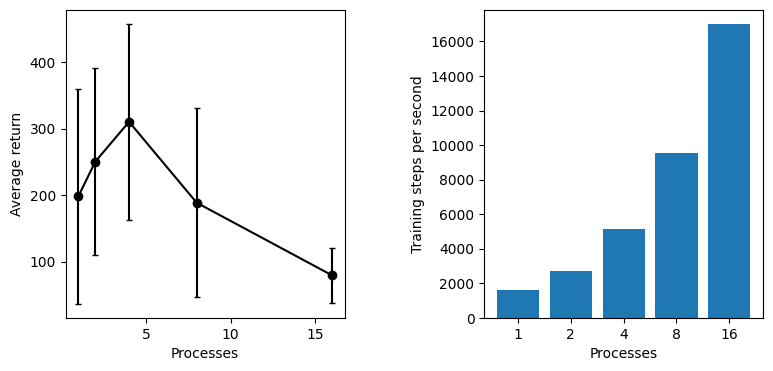

In [30]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

## Sample efficiency vs wall clock time trade-off
There is clearly a trade-off between sample efficiency, diverse experience and wall clock time. Let's try getting the best performance in a fixed amount of time, say 10 seconds per experiment

In [32]:
SECONDS_PER_EXPERIMENT = 10
steps_per_experiment = [int(SECONDS_PER_EXPERIMENT * fps) for fps in training_steps_per_second]
reward_averages = []
reward_std = []
training_times = []

for n_procs, train_steps in zip(PROCESSES_TO_TEST, steps_per_experiment):
    total_procs += n_procs
    print(f"Running for n_procs = {n_procs} for steps = {train_steps}")
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        train_env = make_vec_env(env_id, 
                         n_envs=n_procs,
                         vec_env_cls=SubprocVecEnv, 
                         vec_env_kwargs=dict(start_method='spawn'))
        # Alternatively, you can use a DummyVecEnv if the communication delays is the bottleneck
        # train_env = DummyVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)])

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=train_steps)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))


Running for n_procs = 1 for steps = 15918


/home/egtechlab/anaconda3/envs/mujoco_env/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Running for n_procs = 2 for steps = 27124
Running for n_procs = 4 for steps = 51646
Running for n_procs = 8 for steps = 95311
Running for n_procs = 16 for steps = 169873


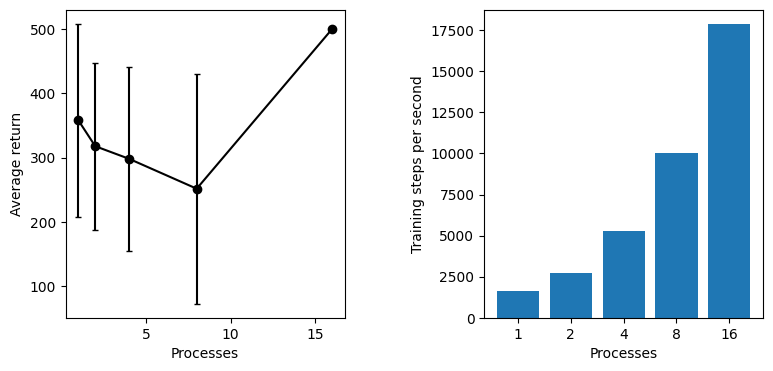

In [33]:
training_steps_per_second = [s / t for s,t in zip(steps_per_experiment, training_times)]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

In [35]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f'Running for n_procs = {n_procs}')
    # Here we are using only one process even for n_env > 1
    # this is equivalent to DummyVecEnv([make_env(env_id, i + total_procs) for i in range(n_procs)])
    train_env = make_vec_env(env_id, n_envs=n_procs)

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1


/home/egtechlab/anaconda3/envs/mujoco_env/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Running for n_procs = 2
Running for n_procs = 4
Running for n_procs = 8
Running for n_procs = 16


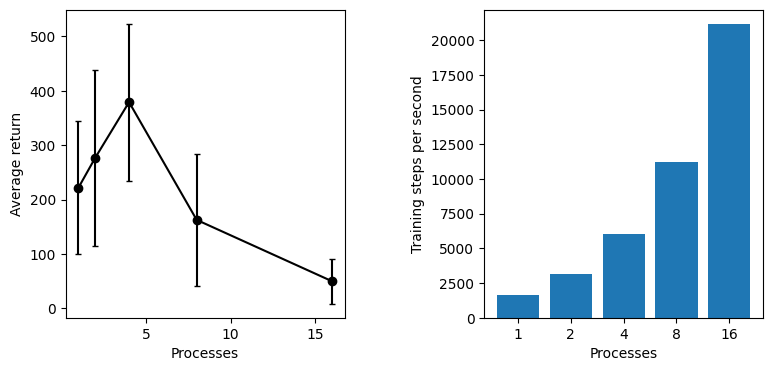

In [36]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plot_training_results(training_steps_per_second, reward_averages, reward_std)